In [748]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble, Aer
from qiskit.circuit.library import ZGate
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [749]:
class Graph:
    EDGE_VERT_START_IDX = 0
    EDGE_VERT_END_IDX = 1
    COST_IDX = 2

    def __build_matrix(self):
        for edge in self.__edges:
            vertex_i = edge[Graph.EDGE_VERT_START_IDX]
            vertex_j = edge[Graph.EDGE_VERT_END_IDX]
            cost_ij = float(edge[Graph.COST_IDX])
            self.__cost_matrix[vertex_i][vertex_j] = cost_ij
            self.__cost_matrix[vertex_j][vertex_i] = cost_ij
    
    def __init__(self, vertices: int, edges: list):
        self.__edges = edges
        self.__vertices = vertices
        self.__cost_matrix = [[0 for column in range(vertices)] for row in range(vertices)]
        self.__build_matrix()

    def evaluate(self, arrangement: str):
        cost = 0.0
        for i in range(len(arrangement)):
            for j in range(len(arrangement)):
                xi: int = int(arrangement[i])
                xj: int = int(arrangement[j])
                cost += self.__cost_matrix[i][j]*xi*(1-xj)
        return cost
        
    def num_vertices(self) -> int:
        return self.__vertices
    
    def get_edges(self) -> list:
        return self.__edges


In [750]:
class QAOA:

    def __prepare(self):
        for i in range(0, self.__qubits):
            self.__circuit.h(self.__inputs[i])    

        # COST LAYER
        for edge in self.__graph.get_edges():
            vertex_i = edge[Graph.EDGE_VERT_START_IDX]
            vertex_j = edge[Graph.EDGE_VERT_END_IDX]
            cost_ij = float(edge[Graph.COST_IDX])
            cost_rotation = cost_ij*self.__gamma
            self.__circuit.cx(vertex_j, vertex_i)
            self.__circuit.rz(cost_rotation, vertex_i)
            self.__circuit.cx(vertex_j, vertex_i)

        self.__circuit.barrier()
        
        # MIX LAYER
        for vertex in range(0, self.__qubits):
            mix_rotation = self.__beta
            self.__circuit.rx(mix_rotation, vertex)
        self.__circuit.draw('mpl').savefig('max_cut_circuit.png')
        
    def __init__(self, graph: Graph, gamma: float, beta: float):
        self.__graph = graph
        self.__qubits = graph.num_vertices()
        self.__gamma = gamma
        self.__beta = beta
        self.__inputs = QuantumRegister(self.__qubits)
        self.__outputs = ClassicalRegister(self.__qubits)
        self.__circuit = QuantumCircuit(self.__inputs, self.__outputs)
        self.__simulator = Aer.get_backend('aer_simulator')
        self.__results = None
    
    def measure(self):
        self.__prepare()
        self.__circuit.measure(self.__inputs, self.__outputs)
        qasm_sim = Aer.get_backend('qasm_simulator')
        transpiled_circuit = transpile(self.__circuit, qasm_sim)
        self.__results = qasm_sim.run(transpiled_circuit).result()
    
    def update(self, gamma: float, beta: float):
        self.__circuit.clear()
        self.__gamma = gamma
        self.__beta = beta

    def get_results(self):
        return self.__results

In [751]:
import math
class Evaluator:

    def __init__(self, graph: Graph):
        self.__graph = graph
    
    def evaluate(self, samples: dict):
        cost_fn = 0
        total_samples = 0
        for sample in samples:
            occurences: int = samples[sample]
            single_occ_cost: float = graph.evaluate(sample)
            cumulative_occ_cost: float = single_occ_cost*occurences
            cost_fn += cumulative_occ_cost
            total_samples += occurences
        return cost_fn/total_samples


In [847]:
class ClassicalOptimizer:
    GAMMA_IDX = 0
    BETA_IDX = 1
    # 0.2, -0.6

    def __init__(self):
        self.__params = [-1, 8];
        self.__best_params = [-1, 8];
        self.__mutation_factor = 0.1;
        self.__best_cost = -9999;
        self.__prev = [];
        self.__gamma_step = 0.1;
        self.__beta_step = 0.1;
        
    def optimize(self, cost: float) -> list:
        if self.__best_cost < cost:
            self.__best_cost = cost
            self.__best_params[ClassicalOptimizer.GAMMA_IDX] = self.__params[ClassicalOptimizer.GAMMA_IDX]
            self.__best_params[ClassicalOptimizer.BETA_IDX] = self.__params[ClassicalOptimizer.BETA_IDX]
        
        if len(self.__prev) == 0:
            self.__prev.append(cost)
        else:
            prev = self.__prev[0]
            self.__prev.clear()
            if(cost < prev):
                self.__gamma_step = -self.__gamma_step*self.__mutation_factor;
                self.__beta_step = -self.__beta_step*self.__mutation_factor;
        self.__params[ClassicalOptimizer.GAMMA_IDX] += self.__gamma_step;
        self.__params[ClassicalOptimizer.BETA_IDX] += self.__beta_step;

    def get_best(self):
        return self.__best_params
        
    def get_params(self):
        return self.__params

In [848]:
class MaxcutQAOA:
    GAMMA_INIT = 0.5
    BETA_INIT = 30

    def __init__(self, graph: Graph, iter=5):
        self.__evaluator = Evaluator(graph)
        self.__optimizer = ClassicalOptimizer()
        init_params: list = self.__optimizer.get_params()
        self.__ansatz = QAOA(graph, gamma=init_params[ClassicalOptimizer.GAMMA_IDX] , beta=init_params[ClassicalOptimizer.BETA_IDX])
        self.__iter = iter
        
    def solve(self):
        for iter in range(0, self.__iter):
            self.__ansatz.measure()
            fn: float = evaluator.evaluate(self.__ansatz.get_results().get_counts())
            self.__optimizer.optimize(fn)
            new_params: list = self.__optimizer.get_params()
            self.__ansatz.update(new_params[ClassicalOptimizer.GAMMA_IDX], new_params[ClassicalOptimizer.BETA_IDX])
    
    def results(self):
        return self.__ansatz.get_results()

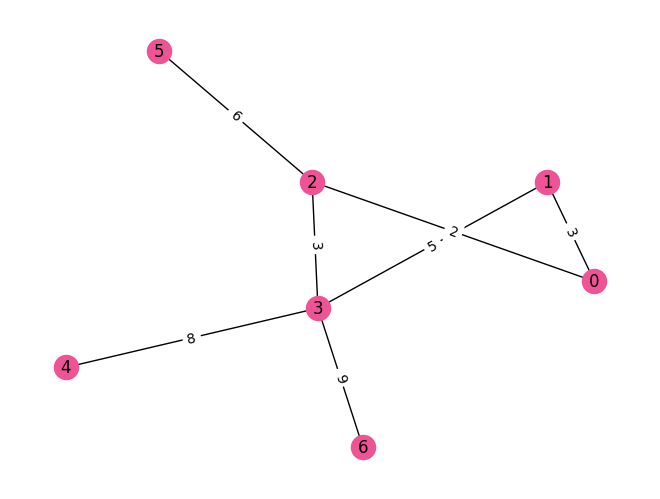

In [849]:
# EDGE: ((VERTEX i, VERTEX j), COST)
vertices = 7
edges = [(0, 1, 3),
         (0, 2, 2),
         (1, 3, 5),
         (2, 3, 3),
         (3, 4, 8),
         (2, 5, 6),
         (3, 6, 9)]
G = rx.PyGraph()
G.add_nodes_from(range(vertices))
G.add_edges_from(edges)
mpl_draw(
    G, with_labels=True, node_color="#EE5396", font_color="#000000", edge_labels=str
)
graph = Graph(vertices, edges)

In [850]:
maxcut_qaoa_solver = MaxcutQAOA(graph, iter=30)
maxcut_qaoa_solver.solve()


In [851]:
total_samples = maxcut_qaoa_solver.results().get_counts()
max = 0
best = ''
classical_max = 0
classical_best = ''
for sample in total_samples:
    eval_sample = graph.evaluate(sample)
    if classical_max < eval_sample:
        classical_best = sample
        classical_max = eval_sample
    if max < total_samples[sample]:
        max = total_samples[sample]
        best = sample
print("Quantum Max Cut Cost = "+best)
print("Quantum Max Cut = ",graph.evaluate(best))
print("Classical Max Cut Cost = "+classical_best)
print("Classical Max Cut = ",classical_max)

Quantum Max Cut Cost = 1100101
Quantum Max Cut =  24.0
Classical Max Cut Cost = 0110101
Classical Max Cut =  36.0


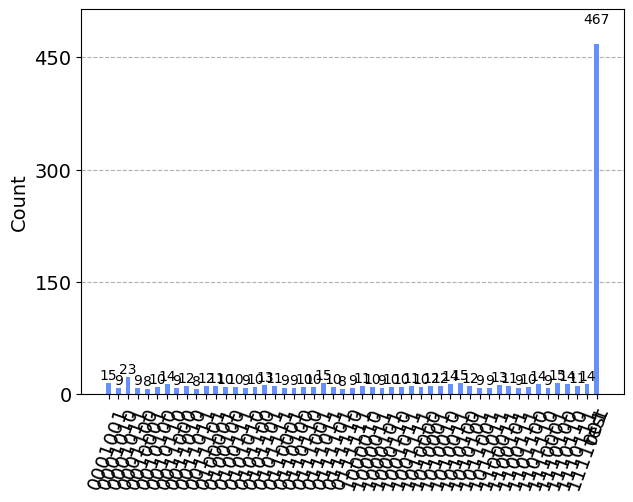

In [812]:
plot_histogram(maxcut_qaoa_solver.results().get_counts(), number_to_keep=50)


Quantum Max Cut Cost = 001010
Quantum Max Cut =  6.0
Classical Max Cut Cost = 010110
Classical Max Cut =  8.0


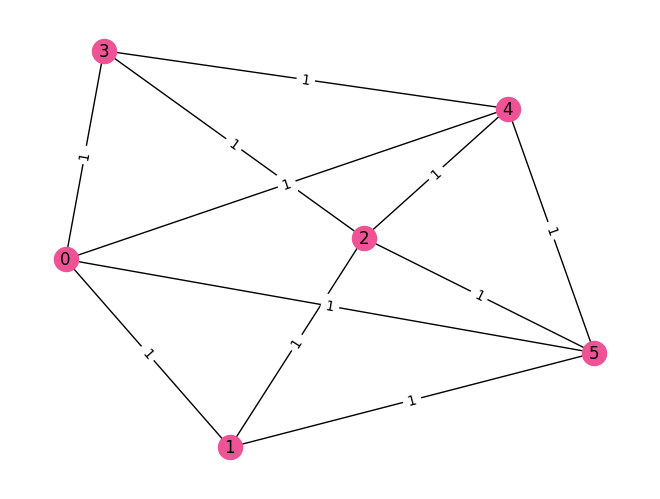

In [813]:
# EDGE: ((VERTEX i, VERTEX j), COST)
vertices = 6
edges = [(0, 1, 1),
         (0, 3, 1),
         (0, 4, 1),
         (0, 5, 1),
         (1, 2, 1),
         (1, 5, 1),
         (2, 3, 1),
         (2, 4, 1),
         (2, 5, 1),
         (3, 4, 1),
         (4, 5, 1)]
G = rx.PyGraph()
G.add_nodes_from(range(vertices))
G.add_edges_from(edges)
mpl_draw(
    G, with_labels=True, node_color="#EE5396", font_color="#000000", edge_labels=str
)
graph = Graph(vertices, edges)

maxcut_qaoa_solver = MaxcutQAOA(graph, iter=30)
maxcut_qaoa_solver.solve()

total_samples = maxcut_qaoa_solver.results().get_counts()
max = 0
best = ''
classical_max = 0
classical_best = ''
for sample in total_samples:
    eval_sample = graph.evaluate(sample)
    if classical_max < eval_sample:
        classical_best = sample
        classical_max = eval_sample
    if max < total_samples[sample]:
        max = total_samples[sample]
        best = sample
print("Quantum Max Cut Cost = "+best)
print("Quantum Max Cut = ",graph.evaluate(best))
print("Classical Max Cut Cost = "+classical_best)
print("Classical Max Cut = ",classical_max)

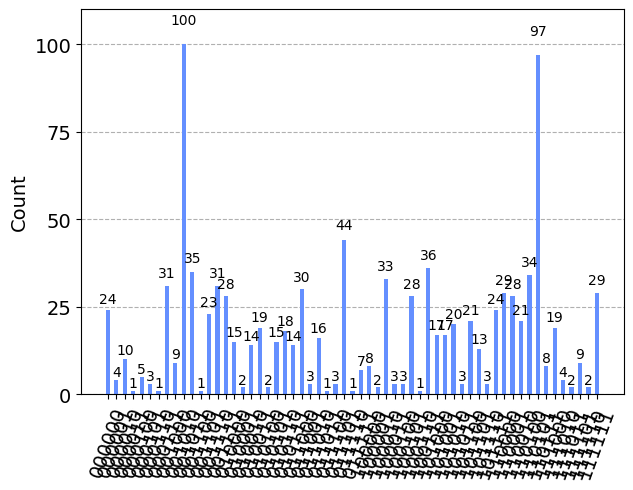

In [814]:
plot_histogram(maxcut_qaoa_solver.results().get_counts())


01001
38.0
01001
38.0


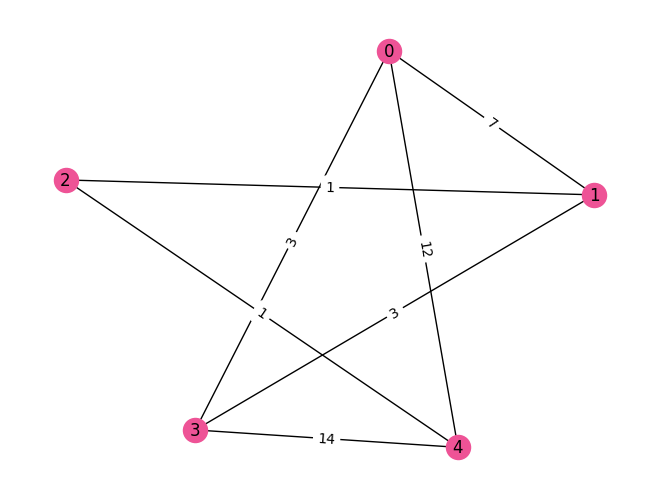

In [815]:
# EDGE: ((VERTEX i, VERTEX j), COST)
vertices = 5
edges = [(0, 1, 7),
         (0, 3, 3),
         (0, 4, 12),
         (1, 2, 1),
         (1, 3, 3),
         (2, 4, 1),
         (3, 4, 14)]
G = rx.PyGraph()
G.add_nodes_from(range(vertices))
G.add_edges_from(edges)
mpl_draw(
    G, with_labels=True, node_color="#EE5396", font_color="#000000", edge_labels=str
)
graph = Graph(vertices, edges)

maxcut_qaoa_solver = MaxcutQAOA(graph, iter=30)
maxcut_qaoa_solver.solve()

total_samples = maxcut_qaoa_solver.results().get_counts()
max = 0
best = ''
classical_max = 0
classical_best = ''
for sample in total_samples:
    eval_sample = graph.evaluate(sample)
    if classical_max < eval_sample:
        classical_best = sample
        classical_max = eval_sample
    if max < total_samples[sample]:
        max = total_samples[sample]
        best = sample
print(best)
print(graph.evaluate(best))
print(classical_best)
print(classical_max)

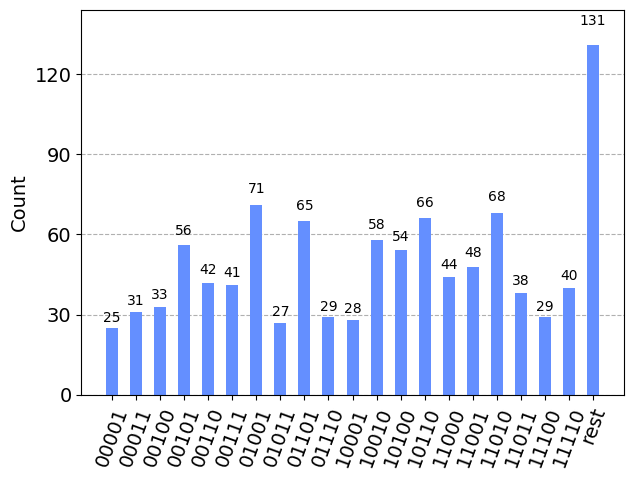

In [816]:
plot_histogram(maxcut_qaoa_solver.results().get_counts(), number_to_keep=20)


In [817]:
print("Quantum Max Cut Cost = "+best)
print("Quantum Max Cut = ",graph.evaluate(best))
print("Classical Max Cut Cost = "+classical_best)
print("Classical Max Cut = ",classical_max)

Quantum Max Cut Cost = 01001
Quantum Max Cut =  38.0
Classical Max Cut Cost = 01001
Classical Max Cut =  38.0
